In [470]:
#%pip install torch torchvision
#%pip install opencv-contrib-python
#%pip install scikit-learn
#%pip install matplotlib
#%pip install pandas
#%pip install numpy

In [471]:
# OUR SOURCE : https://blog.paperspace.com/object-localization-pytorch-2/
# Python 3-9

import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import torch
import time
import PIL
from torch import optim
import os
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import optim
import tqdm


In [472]:
train, test = train_test_split(pd.read_csv("../../annotation_dataset_formated.csv"),test_size=0.2)
img_dir = "../../dataset/"
print(test)

     filename  ax1  ay1  bx2  by2
7      7.jpeg   99  196   64  170
57    57.jpeg  133  199  130  179
76    76.jpeg  141  199  146  180
73    73.jpeg   95  197  104  176
30    30.jpeg   77  198   68  192
110  110.jpeg   75  200  100  172
87    87.jpeg  121  198  124  173
94    94.jpeg  155  199  150  189
97    97.jpeg   87  199  113  180
6      6.jpeg   91  197  119  172
98    98.jpeg  128  198  157  172
96    96.jpeg   47  200   35  184
102  102.jpeg  125  198  122  183
63    63.jpeg  106  200  140  165
59    59.jpeg  138  200  115  156
90    90.jpeg  107  198   83  167
25    25.jpeg  129  198  106  186
100  100.jpeg  113  199   72  174
22    22.jpeg  132  199   79  191
81    81.jpeg  167  198  141  176
78    78.jpeg  148  198  148  162
80    80.jpeg  161  199  131  173
65    65.jpeg  121  198  125  179


In [473]:
import cv2
def open_images(paths):
        images = []
        for path in paths:
                with PIL.Image.open(img_dir + path) as image:
                        images.append(np.asarray(image))
                
        return np.array(images)

def preprocess_images(images):
        processed_images = []
        for image in images:
                processed_image = cv2.Canny(image, 60, 200)

                # put a opacity of the original image back in
                processed_image = np.where(processed_image == 0, image, processed_image)
                #processed_image[:150] = 0
                
                processed_images.append(np.expand_dims(processed_image, axis= 2))
                
        return np.array(processed_images)

In [474]:
import cv2
#make edges detection on images

train_img = open_images(train["filename"])
test_img = open_images(test["filename"])
train_img = preprocess_images(train_img)
test_img = preprocess_images(test_img)
train_img.shape

(91, 200, 200, 1)

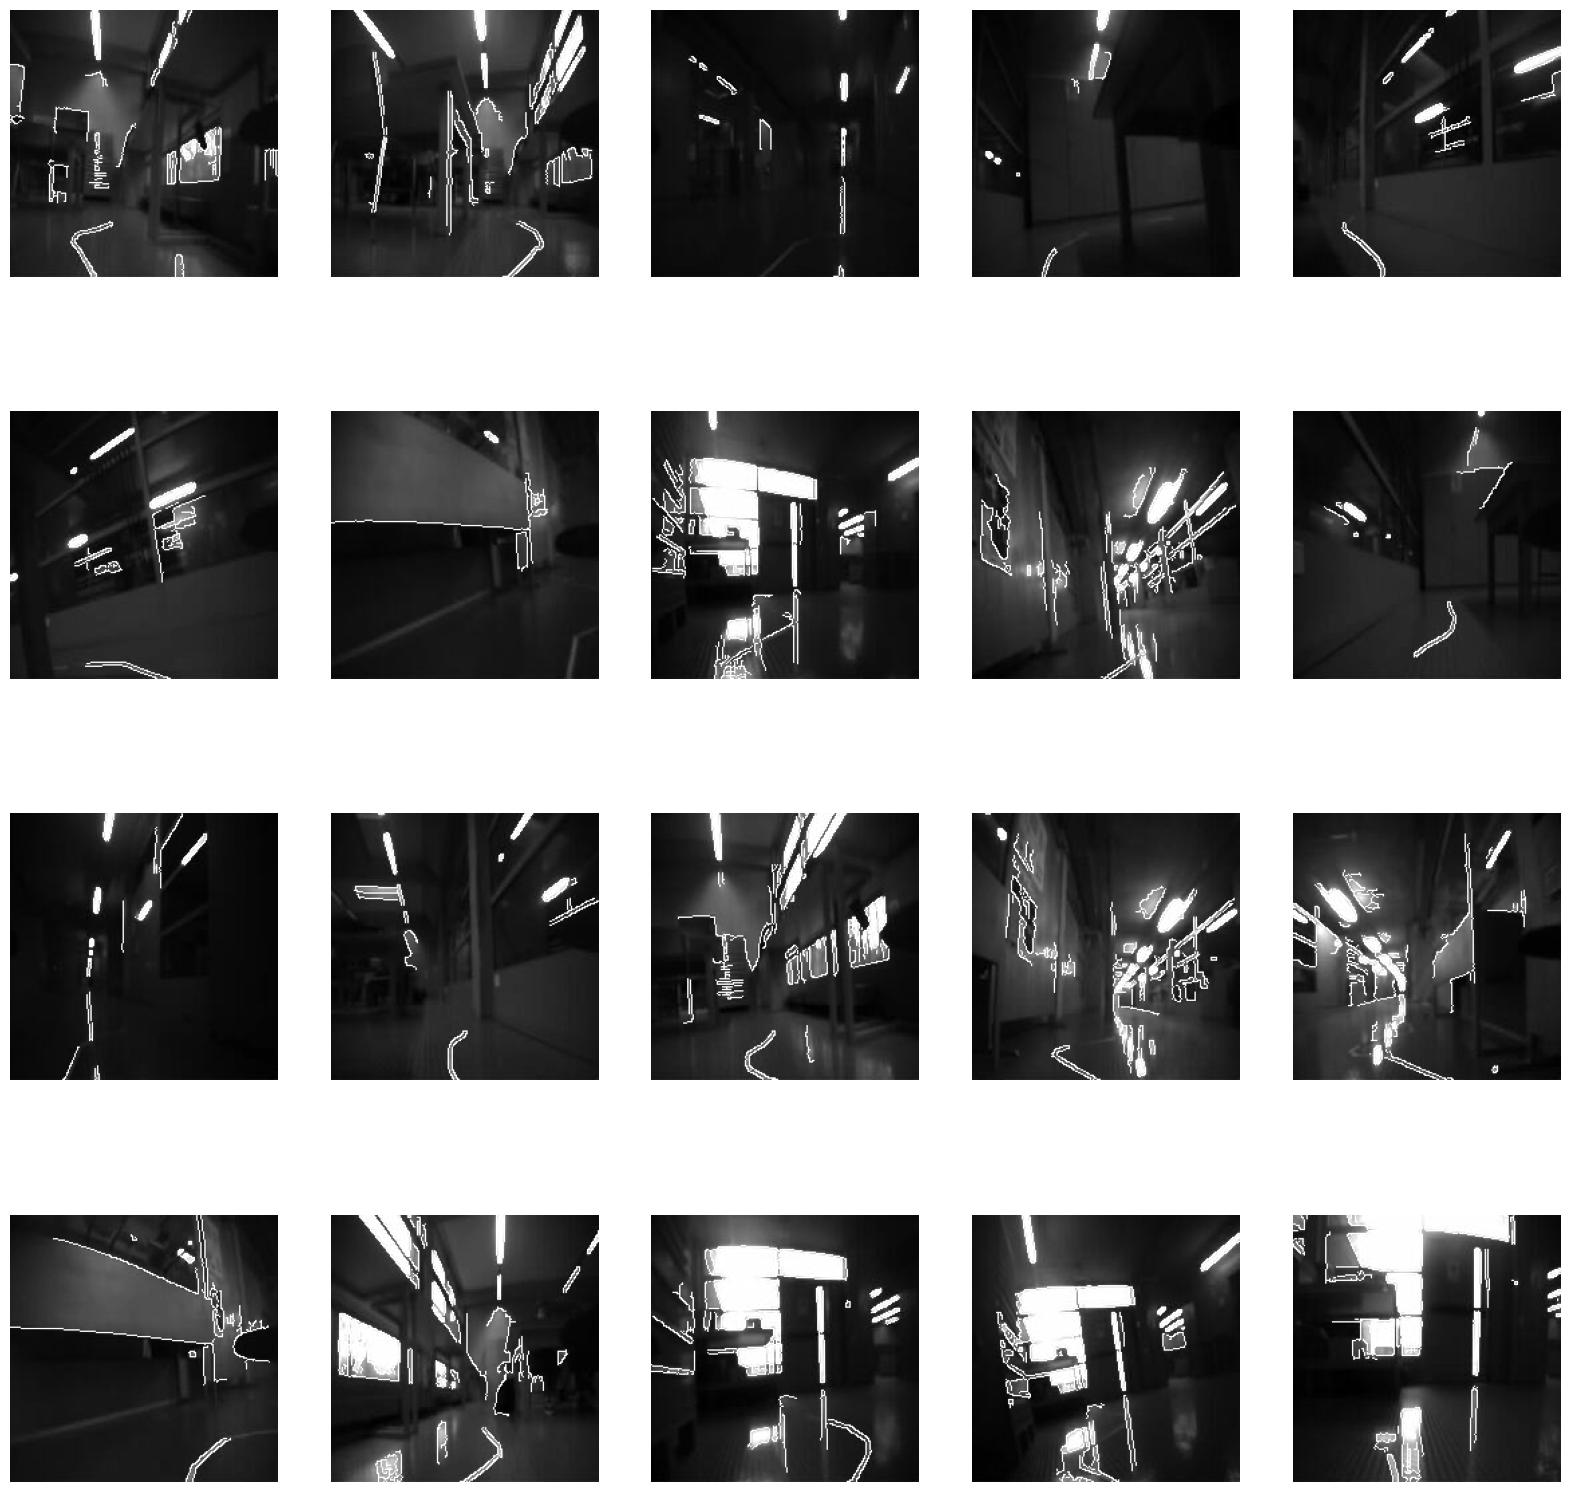

In [475]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(train_img)), 20)

for itr, i in enumerate(random_range, 1):



    image = train_img[i]


# Clip the values to 0-1 and draw the sample of images
    
    plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()


In [476]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [477]:
class Dataset():
    def __init__(self, train_images, train_coords):
        self.images = torch.from_numpy(train_images).float()
        self.coords = torch.from_numpy(train_coords).float()

    def __len__(self):
        return len(self.coords)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.coords[idx])

train_coords = train.loc[:,('ax1','ay1','bx2','by2')].values
test_coords = test.loc[:,('ax1','ay1','bx2','by2')].values

dataset_train = Dataset(np.transpose(train_img,(0,3,1,2)),train_coords)
dataset_test = Dataset(np.transpose(test_img,(0,3,1,2)),test_coords)

print(dataset_train[0][0].shape)

torch.Size([1, 200, 200])


In [478]:
# OUR MODEL 
class CNN(Module):
    def __init__(self):
        # call the parent constructor
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)

        self.box_fc1 = nn.Linear(in_features=192, out_features=124)
        self.box_fc2 = nn.Linear(in_features=124, out_features=64)
        self.box_out = nn.Linear(in_features=64, out_features=4)

    def forward(self, t):
        # normalize pixel value
        t = t / 256
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=-3)
    

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        output = F.sigmoid(box_t)

        return output *200
model = CNN()
model = model.to(device)
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (box_fc1): Linear(in_features=192, out_features=124, bias=True)
  (box_fc2): Linear(in_features=124, out_features=64, bias=True)
  (box_out): Linear(in_features=64, out_features=4, bias=True)
)

In [479]:
dataloader = torch.utils.data.DataLoader(
       dataset_train, batch_size=32)
valdataloader = torch.utils.data.DataLoader(
       dataset_test, batch_size=32)

MSE: 556.39
RMSE: 23.59


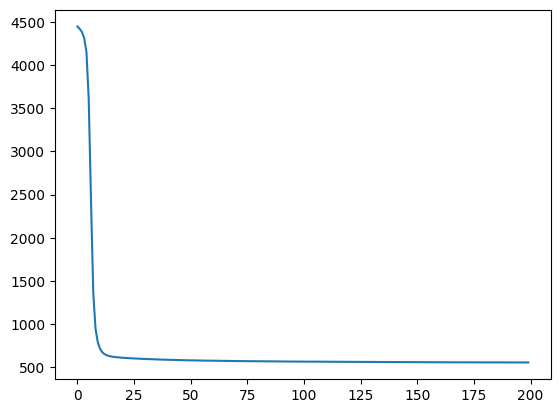

In [480]:
X_train = torch.tensor(np.transpose(train_img,(0,3,1,2)) , dtype=torch.float32)
y_train = torch.tensor(train_coords, dtype=torch.float32)
X_test = torch.tensor(np.transpose(test_img,(0,3,1,2)), dtype=torch.float32)
y_test = torch.tensor(test_coords, dtype=torch.float32)
 
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 2  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
#model.load_state_dict(best_weights)

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [481]:
def predict(model , image):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(np.transpose(image,(2,1,0))).float()
        image = image.to(device)
        outputs = model(image)
    return outputs.cpu().numpy()

In [482]:

# OUR PREDICTION
image = test_img[0]

print(image.shape)


pred = predict(model, image)
print(pred)
print(test_coords[0])


(200, 200, 1)
[ 99.9241  199.99397  90.80711 186.05435]
[ 99 196  64 170]


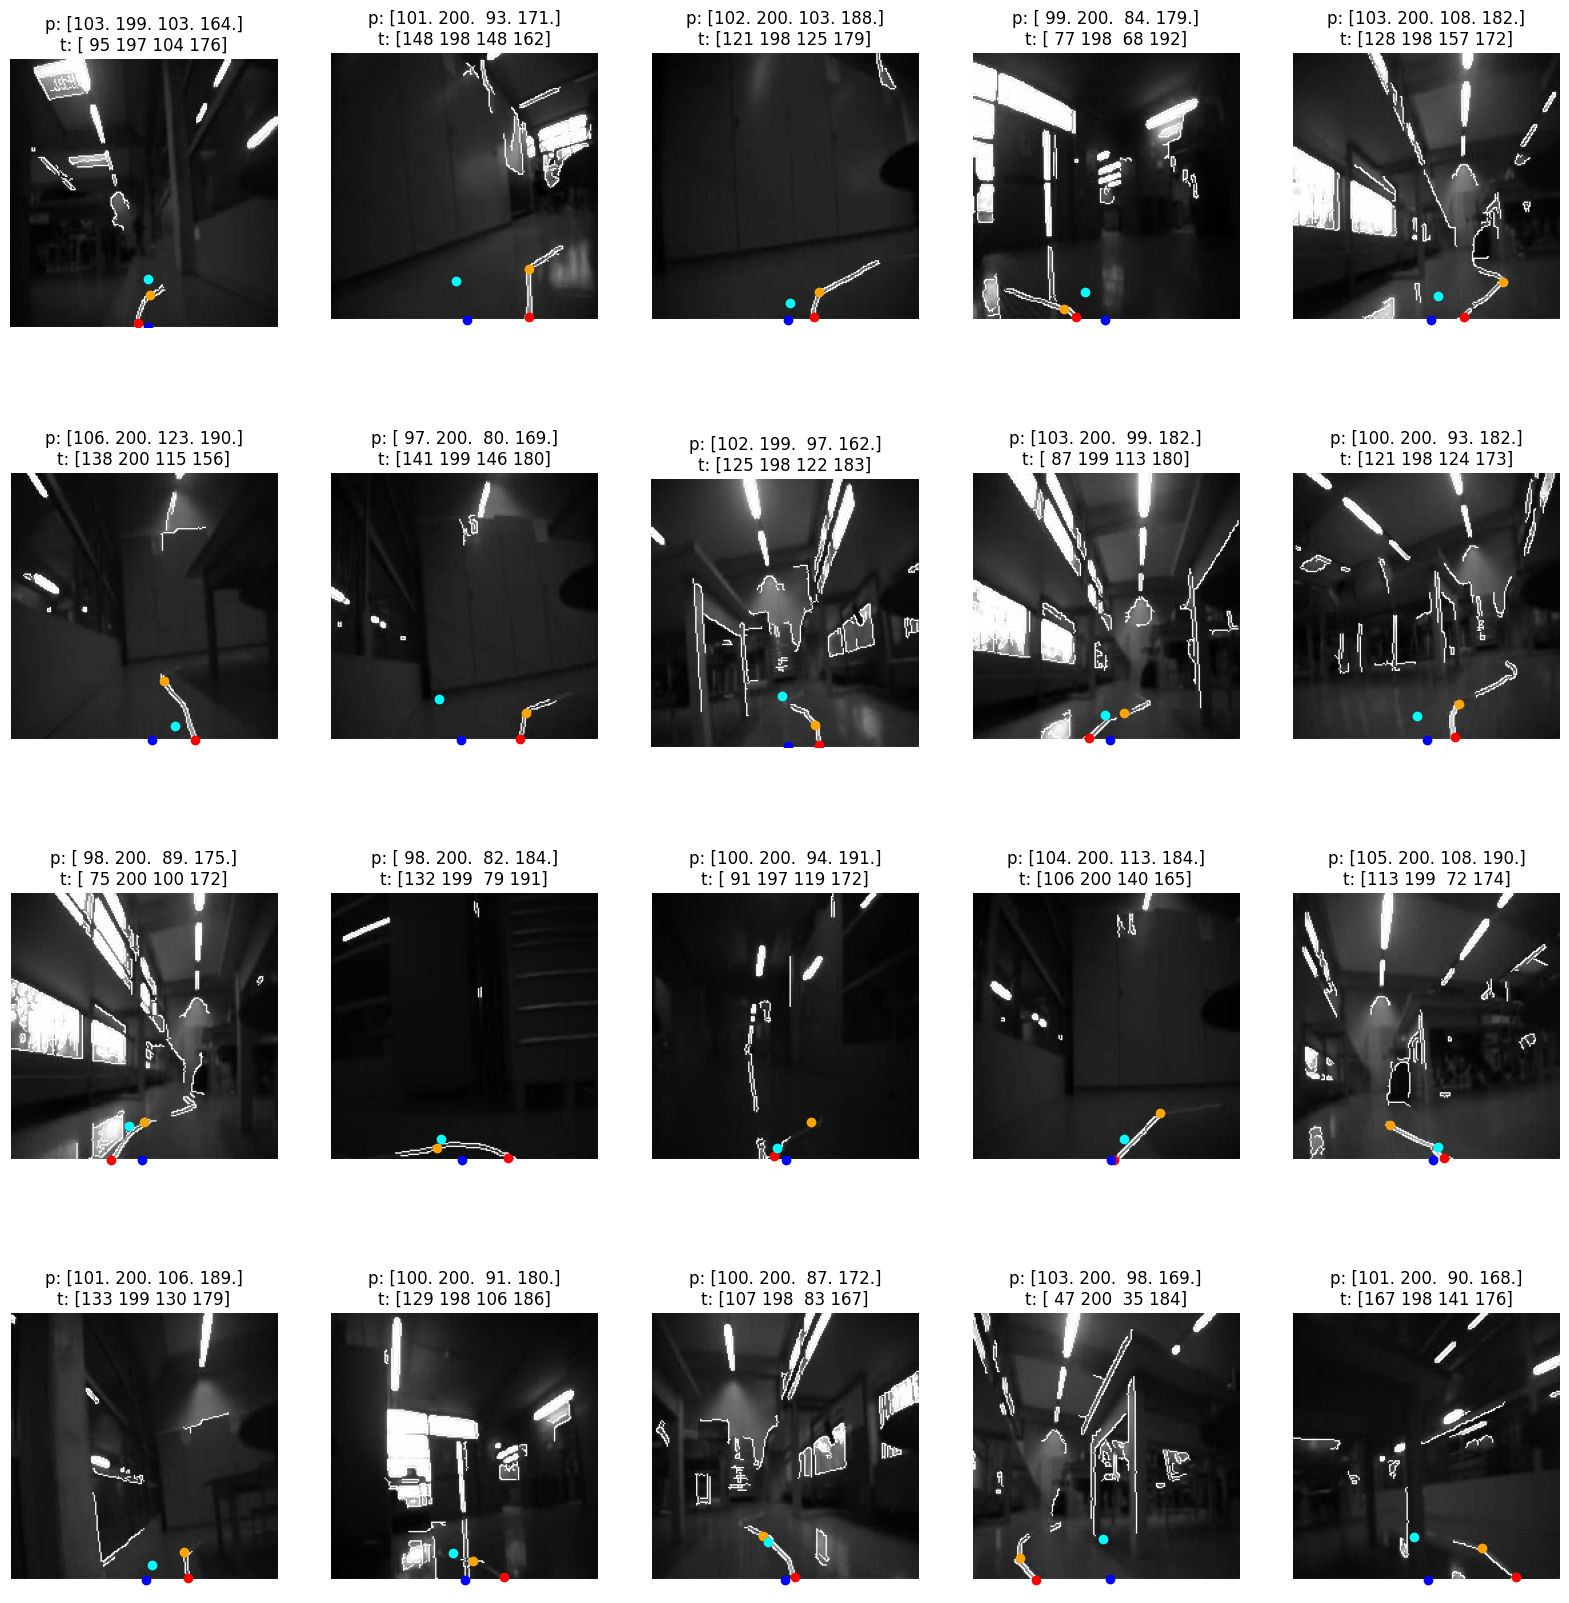

In [483]:
# Generate a random sample of images each time the cell is run
random_range = random.sample(range(1, len(test_img)), 20)

# Create a Matplotlib figure
plt.figure(figsize=(20,20))

for itr, i in enumerate(random_range, 1):
    coords = test_coords[i]
    output = predict(model, train_img[i])

    # Clip the values to 0-1 and draw the sample of images
    plt.subplot(4, 5, itr)
    plt.imshow(test_img[i], cmap='gray')
    plt.axis('off')
    plt.title("p: " + str(np.round(output)) + "\nt: " + str(coords))

    # Plot the ground truth points with red variation
    plt.scatter(coords[0], coords[1], c='red', marker='o', label='Ground Truth A')
    plt.scatter(coords[2], coords[3], c='orange', marker='o', label='Ground Truth B')

    # Plot the prediction points with blue variation
    plt.scatter(output[0], output[1], c='blue', marker='o', label='Prediction A')
    plt.scatter(output[2], output[3], c='cyan', marker='o', label='Prediction B')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()
